In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install einops
!pip install deeplake

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from einops import rearrange

from latex import latexify
latexify(columns = 2)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

manualSeed = 999
#manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

cuda
Random Seed:  999


In [ ]:
import deeplake
ds = deeplake.load("hub://activeloop/ffhq")[:5000]

/

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/ffhq



/

hub://activeloop/ffhq loaded successfully.



/usr/local/lib/python3.10/dist-packages/deeplake/api/dataset.py:841: UserWarning: Dataset has more than 20 tensors. Skipping integrity check. Specify `check_integrity=True` to perform integrity check.
  warnings.warn(



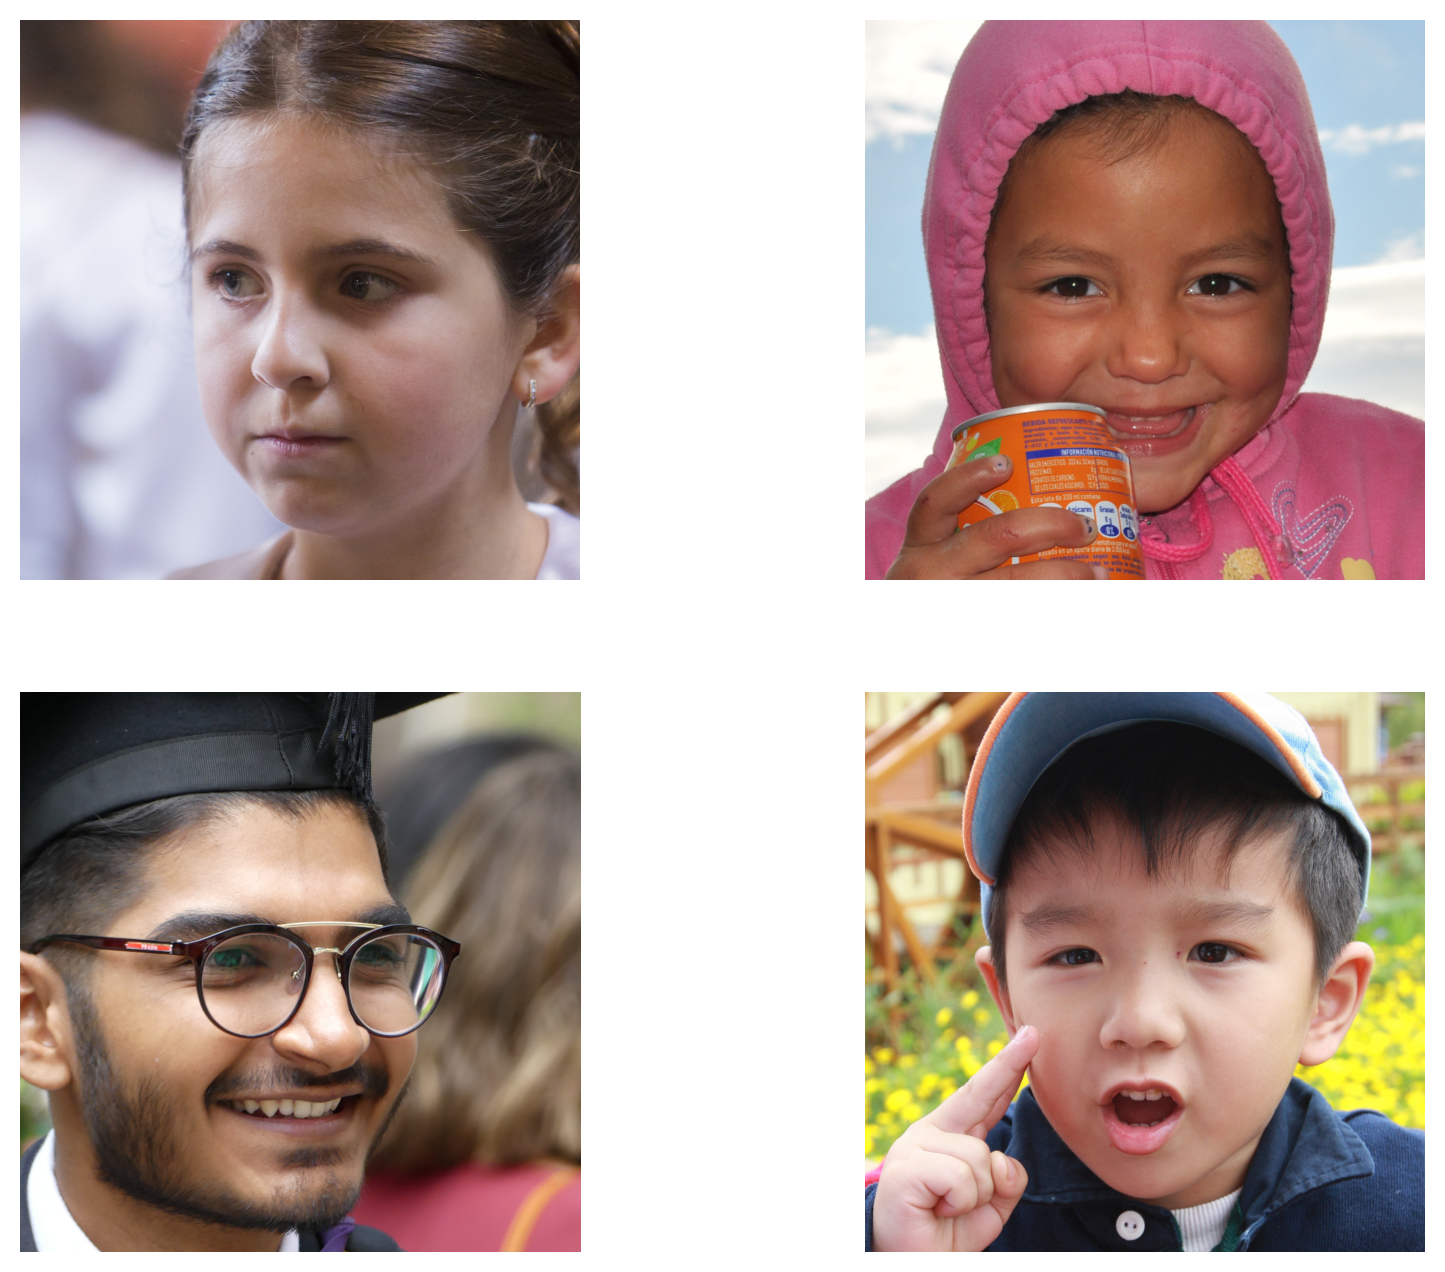

In [ ]:
import random
idx = random.sample(range(0, 5000), 4)
plt.figure(figsize = (10, 8))
plt.subplot(2, 2, 1)
plt.imshow(ds.images_1024.image[idx[0]])
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(ds.images_1024.image[idx[1]])
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(ds.images_1024.image[idx[2]])
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(ds.images_1024.image[idx[3]])
plt.axis("off")

plt.show()

In [ ]:
batch_size = 32
image_size = 1024
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 2e-4
beta1 = 0.5

In [ ]:
tform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5 for _ in range(nc)], [0.5 for _ in range(nc)])])

In [ ]:
dataloader = ds.pytorch(num_workers = 1, shuffle = True, tensors = ["images_1024/image"], transform = {'images_1024/image': tform}, batch_size = batch_size, decode_method = {'images_1024/image': 'pil'})

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, feature_d):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, feature_d, kernel_size = 4, stride = 2, padding = 1),
            # BatchNorm is skipped for the first layer
            nn.LeakyReLU(0.2),
            self._block(feature_d, feature_d * 2, 4, 2, 1),
            self._block(feature_d * 2, feature_d * 4, 4, 2, 1),
            self._block(feature_d * 4, feature_d * 8, 4, 2, 1),
            nn.Conv2d(feature_d * 8, 1, kernel_size = 4, stride = 2, padding = 0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, feature_g):
        super().__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, feature_g * 16, 4, 1, 0),
            self._block(feature_g * 16, feature_g * 8, 4, 2, 1),
            self._block(feature_g * 8, feature_g * 4, 4, 2, 1),
            self._block(feature_g * 4, feature_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(feature_g * 2, channels_img, kernel_size = 4, stride = 2, padding = 1),
            # No BatchNorm here and Tanh is used in the last layer
            nn.Tanh(),
            # image transformed to be in [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            # Initialized with mean 0 and std 0.02

In [ ]:
gen = Generator(nz, nc, ngf).to(device)
disc = Discriminator(nc, ndf).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [ ]:
opt_gen = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr = lr, betas = (beta1, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [ ]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 1.90G/1.91G [01:52<00:00, 18.1MB/s]


Shuffle buffer filling is complete.


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/5], Batch Step [0/157], Loss D: 0.6905, Loss G: 0.8058


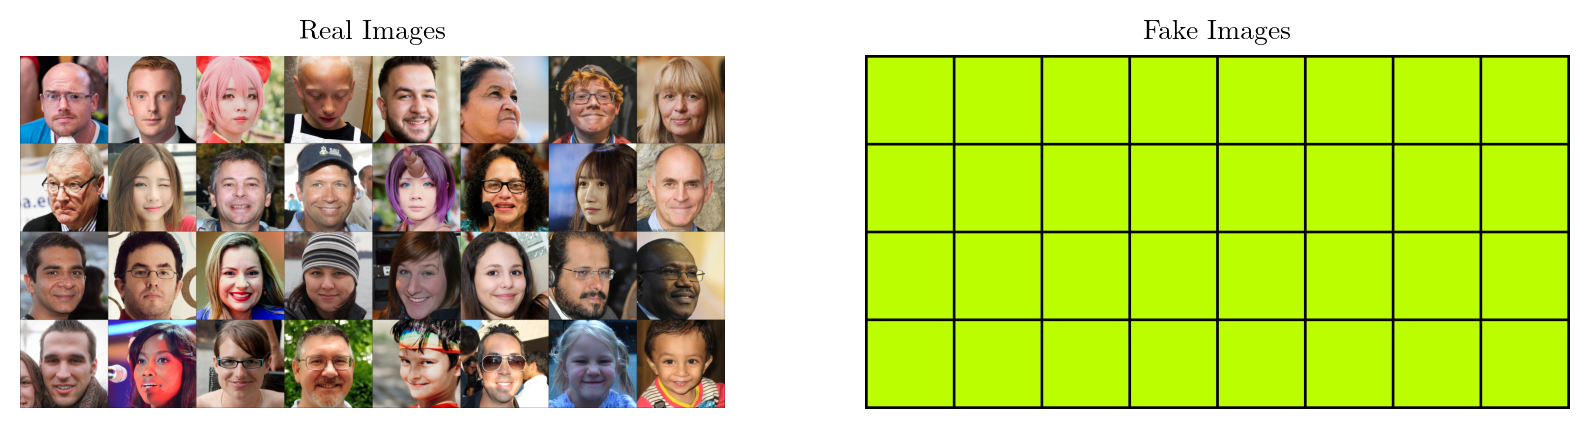

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, data in enumerate(dataloader):
        real = data["images_1024/image"]
        real = real.to(device)
        noise = torch.randn(batch_size, nz, 1, 1).to(device)
        fake = gen(noise)

        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        # BCE(Real, 1) = -log(Real)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)

        # BCE(Fake, 0) = -log(1 - Fake) = -log(Fake)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        disc.zero_grad()
        loss_disc.backward(retain_graph = True)
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        # BCE(Fake, 1) = -log(Fake)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch Step [{batch_idx}/{len(dataloader)}], Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

            with torch.no_grad():
                # infer from the Generator by plotting the generated images
                gen.eval()
                fake_noise = torch.randn(32, nz, 1, 1).to(device)
                fake = gen(fake_noise)
                img_grid_real = vutils.make_grid(real[:32], normalize = True)
                img_grid_fake = vutils.make_grid(fake[:32], normalize = True)

                plt.figure(figsize = (10, 10))
                plt.subplot(1, 2, 1)
                plt.axis("off")
                plt.title("Real Images")
                plt.imshow(np.transpose(img_grid_real.cpu().detach().numpy(), (1, 2, 0)))

                plt.subplot(1, 2, 2)
                plt.axis("off")
                plt.title("Fake Images")
                plt.imshow(np.transpose(img_grid_fake.cpu().detach().numpy(), (1, 2, 0)))
                plt.show()

                img = transforms.ToPILImage()(img_grid_fake)
                if not os.path.exists("./DCGAN/FFHQ"):
                    os.makedirs("./DCGAN/FFHQ")
                img.save(f"./DCGAN/FFHQ/{epoch}_{batch_idx}.png")
                gen.train()
            del real

    torch.save(gen.state_dict(), "ffhq_gen.pth")
    torch.save(disc.state_dict(), "ffhq_disc.pth")